In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import random

# model imports
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA

# processing imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score,precision_recall_curve, roc_curve, auc



In [ ]:
# fetch the training file
file_path_20_percent = '/content/KDDTest+.txt'
file_path_full_training_set = '/content/KDDTrain+.txt'
file_path_test = '/content/KDDTest+.txt'

#df = pd.read_csv(file_path_20_percent)
df = pd.read_csv(file_path_full_training_set)
test_df = pd.read_csv(file_path_test)

In [ ]:
# add the column labels
columns = (['duration'
,'protocol_type'
,'service'
,'flag'
,'src_bytes'
,'dst_bytes'
,'land'
,'wrong_fragment'
,'urgent'
,'hot'
,'num_failed_logins'
,'logged_in'
,'num_compromised'
,'root_shell'
,'su_attempted'
,'num_root'
,'num_file_creations'
,'num_shells'
,'num_access_files'
,'num_outbound_cmds'
,'is_host_login'
,'is_guest_login'
,'count'
,'srv_count'
,'serror_rate'
,'srv_serror_rate'
,'rerror_rate'
,'srv_rerror_rate'
,'same_srv_rate'
,'diff_srv_rate'
,'srv_diff_host_rate'
,'dst_host_count'
,'dst_host_srv_count'
,'dst_host_same_srv_rate'
,'dst_host_diff_srv_rate'
,'dst_host_same_src_port_rate'
,'dst_host_srv_diff_host_rate'
,'dst_host_serror_rate'
,'dst_host_srv_serror_rate'
,'dst_host_rerror_rate'
,'dst_host_srv_rerror_rate'
,'attack'
,'level'])


df.columns = columns
test_df.columns = columns

# sanity check
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level
0,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,15
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19
2,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,21
3,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal,21
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21


In [ ]:
is_attack = df.attack.map(lambda a: 0 if a == 'normal' else 1)
test_attack = test_df.attack.map(lambda a: 0 if a == 'normal' else 1)

#data_with_attack = df.join(is_attack, rsuffix='_flag')
df['attack_flag'] = is_attack
test_df['attack_flag'] = test_attack

# view the result
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level,attack_flag
0,0,udp,other,SF,146,0,0,0,0,0,...,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,15,0
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19,1
2,0,tcp,http,SF,232,8153,0,0,0,0,...,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,21,0
3,0,tcp,http,SF,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal,21,0
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21,1


In [ ]:
dos_attacks = ['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm']
probe_attacks = ['ipsweep','mscan','nmap','portsweep','saint','satan']
privilege_attacks = ['buffer_overflow','loadmdoule','perl','ps','rootkit','sqlattack','xterm']
access_attacks = ['ftp_write','guess_passwd','http_tunnel','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','xclock','xsnoop']

# we will use these for plotting below
attack_labels = ['Normal','DoS','Probe','Privilege','Access']

# helper function to pass to data frame mapping
def map_attack(attack):
    if attack in dos_attacks:
        # dos_attacks map to 1
        attack_type = 1
    elif attack in probe_attacks:
        # probe_attacks mapt to 2
        attack_type = 2
    elif attack in privilege_attacks:
        # privilege escalation attacks map to 3
        attack_type = 3
    elif attack in access_attacks:
        # remote access attacks map to 4
        attack_type = 4
    else:
        # normal maps to 0
        attack_type = 0

    return attack_type

# map the data and join to the data set
attack_map = df.attack.apply(map_attack)
df['attack_map'] = attack_map

test_attack_map = test_df.attack.apply(map_attack)
test_df['attack_map'] = test_attack_map

# view the result
df.head()



,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level,attack_flag,attack_map
0,0,udp,other,SF,146,0,0,0,0,0,...,0.88,0.00,0.00,0.00,0.0,0.00,normal,15,0,0
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19,1,1
2,0,tcp,http,SF,232,8153,0,0,0,0,...,0.03,0.04,0.03,0.01,0.0,0.01,normal,21,0,0
3,0,tcp,http,SF,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.0,0.00,normal,21,0,0
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21,1,1


In [ ]:
features_to_encode = ['protocol_type', 'service', 'flag']

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode categorical features
for feature in features_to_encode:
    df[feature] = label_encoder.fit_transform(df[feature])
    test_df[feature] = label_encoder.transform(test_df[feature])

# get numeric features, we won't worry about encoding these at this point
numeric_features = ['duration', 'src_bytes', 'dst_bytes']

# Combine with numeric features as before
to_fit = df[features_to_encode + numeric_features]
test_set = test_df[features_to_encode + numeric_features]

print("shape")
np.shape(df)

shape


(125972, 45)

In [ ]:
binary_y = df['attack_flag']
multi_y = df['attack_map']
test_binary_y = test_df['attack_flag']

# Feature scaling
scaler = StandardScaler()
to_fit_scaled = scaler.fit_transform(to_fit)
test_set_scaled = scaler.transform(test_set)

# build the training sets
binary_train_X, binary_val_X, binary_train_y, binary_val_y = train_test_split(to_fit, binary_y, test_size=0.6)


# Ensure indices are aligned for multi-classification
multi_y = multi_y.loc[binary_train_X.index]


binary_train_X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50388 entries, 60629 to 25634
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   protocol_type  50388 non-null  int64
 1   service        50388 non-null  int64
 2   flag           50388 non-null  int64
 3   duration       50388 non-null  int64
 4   src_bytes      50388 non-null  int64
 5   dst_bytes      50388 non-null  int64
dtypes: int64(6)
memory usage: 2.7 MB


In [ ]:
binary_train_X.sample(5)

,protocol_type,service,flag,duration,src_bytes,dst_bytes
118102,1,8,1,0,0,0
11071,1,24,9,0,296,768
47045,2,44,9,0,516,4
2705,2,49,9,0,105,146
40376,1,24,9,0,301,2454


In [ ]:
# Step 1: Train the first decision tree on resampled data to handle class imbalance
rus = RandomUnderSampler(sampling_strategy={0: int(1/16 * sum(binary_train_y == 0)), 1: sum(binary_train_y == 1)})  # Adjust this ratio based on your dataset
resampled_X, resampled_y = rus.fit_resample(binary_train_X, binary_train_y)
tree1 = DecisionTreeClassifier()
tree1.fit(resampled_X, resampled_y)

# Step 2: Train the second decision tree for normal vs abnormal classification
binary_train_X['prediction_1'] = tree1.predict(binary_train_X)
binary_val_X['prediction_1'] = tree1.predict(binary_val_X)
test_set['prediction_1'] = tree1.predict(test_set)
binary_train_X_resampled, binary_train_y_resampled = rus.fit_resample(binary_train_X, binary_train_y)
tree2 = DecisionTreeClassifier(max_depth=4)
tree2.fit(binary_train_X_resampled, binary_train_y_resampled)

# Step 3: Train the third decision tree for multi-class classification of attacks
abnormal_train_X = binary_train_X[binary_train_y == 1]
abnormal_train_y = multi_y[binary_train_y == 1]
rus_abnormal = RandomUnderSampler(sampling_strategy='auto')  # Adjust this based on your dataset
abnormal_train_X_resampled, abnormal_train_y_resampled = rus_abnormal.fit_resample(abnormal_train_X, abnormal_train_y)
tree3 = DecisionTreeClassifier(max_depth=4)
tree3.fit(abnormal_train_X_resampled, abnormal_train_y_resampled)

<ipython-input-9-e5dcb92337e3>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['prediction_1'] = tree1.predict(test_set)


DecisionTreeClassifier(max_depth=4)

In [ ]:
# Define RandomForest and KNN classifiers
rf = RandomForestClassifier()
knn = KNeighborsClassifier()

# Apply PCA
pca = PCA(n_components=0.95)
binary_train_X_pca = pca.fit_transform(binary_train_X)
binary_val_X_pca = pca.transform(binary_val_X)
test_set_pca = pca.transform(test_set)

# Create the ensemble
ensemble_clf = VotingClassifier(
    estimators=[('multi_tree', tree2), ('rf', rf), ('knn', knn)],
    voting='hard'
)

# Train the ensemble classifier
ensemble_clf.fit(binary_train_X, binary_train_y)

# Make predictions
def multi_tree_predict(X):
    pred1 = tree1.predict(X)
    pred2 = tree2.predict(X)
    final_pred = np.where(pred2 == 0, 0, tree3.predict(X))
    return final_pred


In [ ]:
# Apply PCA
pca = PCA(n_components=0.90)
binary_train_X_pca = pca.fit_transform(binary_train_X)
binary_val_X_pca = pca.transform(binary_val_X)
test_set_pca = pca.transform(test_set)

# Number of selected components
selected_components = pca.n_components_
selected_variance_ratio=pca.explained_variance_ratio_

print("Number of selected components:", selected_components)
print("Explained variance ratio:", selected_variance_ratio)


Number of selected components: 2
Explained variance ratio: [0.76119185 0.238808  ]


In [ ]:
# Number of selected components
n_selected_components = pca.n_components_

# Get the names of the original features
original_feature_names = binary_train_X.columns

# Print the principal components and associated feature names
for component_idx in range(n_selected_components):
    print(f"Principal Component {component_idx + 1}:")
    component_weights = pca.components_[component_idx]
    sorted_indices = np.argsort(np.abs(component_weights))[::-1]  # Sort by absolute weight magnitude
    top_features = original_feature_names[sorted_indices][:10]  # Display top 10 features by weight
    top_weights = component_weights[sorted_indices][:10]
    for feature, weight in zip(top_features, top_weights):
        print(f"{feature}: {weight:.4f}")
    print()


Principal Component 1:
dst_bytes: 1.0000
src_bytes: 0.0005
duration: 0.0000
service: 0.0000
flag: -0.0000
prediction_1: 0.0000
protocol_type: -0.0000

Principal Component 2:
src_bytes: 1.0000
dst_bytes: -0.0005
duration: 0.0000
service: -0.0000
flag: -0.0000
prediction_1: 0.0000
protocol_type: -0.0000



In [ ]:
# Evaluate on validation set
val_predictions = ensemble_clf.predict(binary_val_X)
val_accuracy = accuracy_score(binary_val_y, val_predictions)
val_precision = precision_score(binary_val_y, val_predictions)
val_recall = recall_score(binary_val_y, val_predictions)
val_f1 = f1_score(binary_val_y, val_predictions)

print("Validation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)
print("Validation F1-Score:", val_f1)


Validation Accuracy: 0.9925777942421676
Validation Precision: 0.9908322182045953
Validation Recall: 0.9931792237442922
Validation F1-Score: 0.9920043327679833


In [ ]:
# Evaluate on test set
test_predictions = ensemble_clf.predict(test_set)
test_accuracy = accuracy_score(test_binary_y, test_predictions)
test_precision = precision_score(test_binary_y, test_predictions)
test_recall = recall_score(test_binary_y, test_predictions)
test_f1 = f1_score(test_binary_y, test_predictions)

print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1-Score:", test_f1)

Test Accuracy: 0.8299693918289491
Test Precision: 0.96554578375582
Test Recall: 0.7272443890274314
Test F1-Score: 0.8296217273414233


In [ ]:
# Check for overfitting
train_predictions = ensemble_clf.predict(binary_train_X)
train_accuracy = accuracy_score(binary_train_y, train_predictions)
print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)

Training Accuracy: 0.9936889735651345
Validation Accuracy: 0.9925777942421676


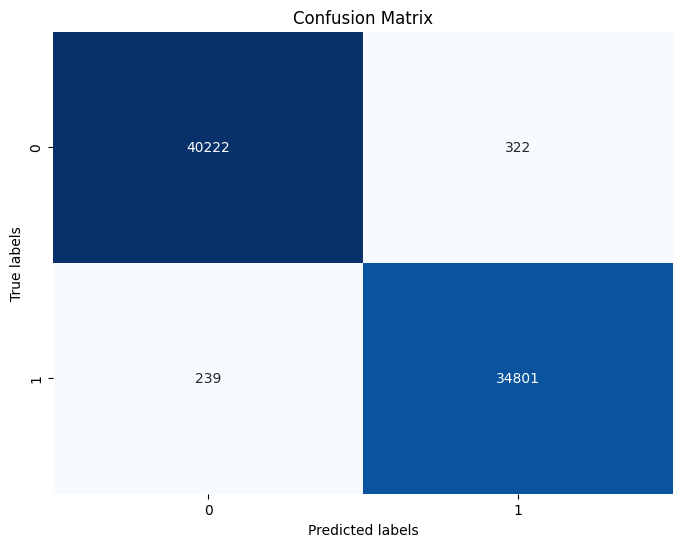

In [ ]:
# Confusion Matrix
cm = confusion_matrix(binary_val_y, val_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


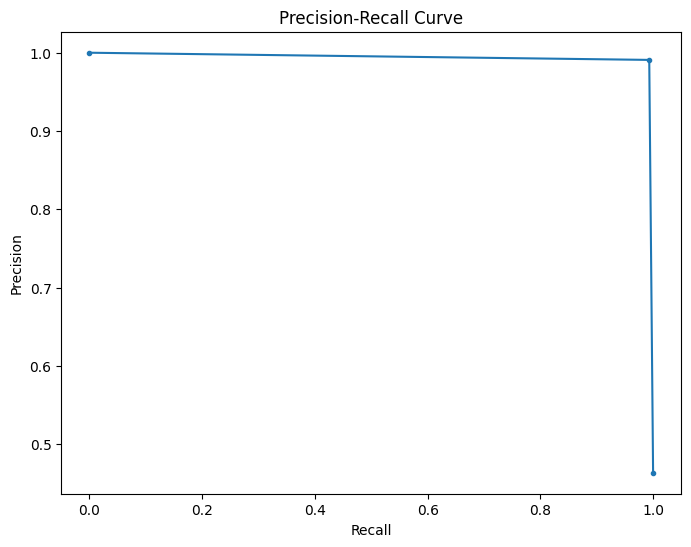

In [ ]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(binary_val_y, val_predictions)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

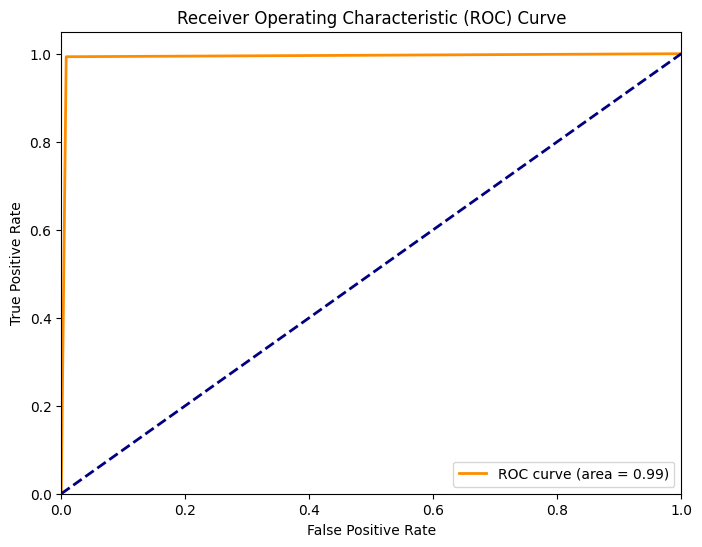

In [ ]:
# ROC Curve
fpr, tpr, _ = roc_curve(binary_val_y, val_predictions)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

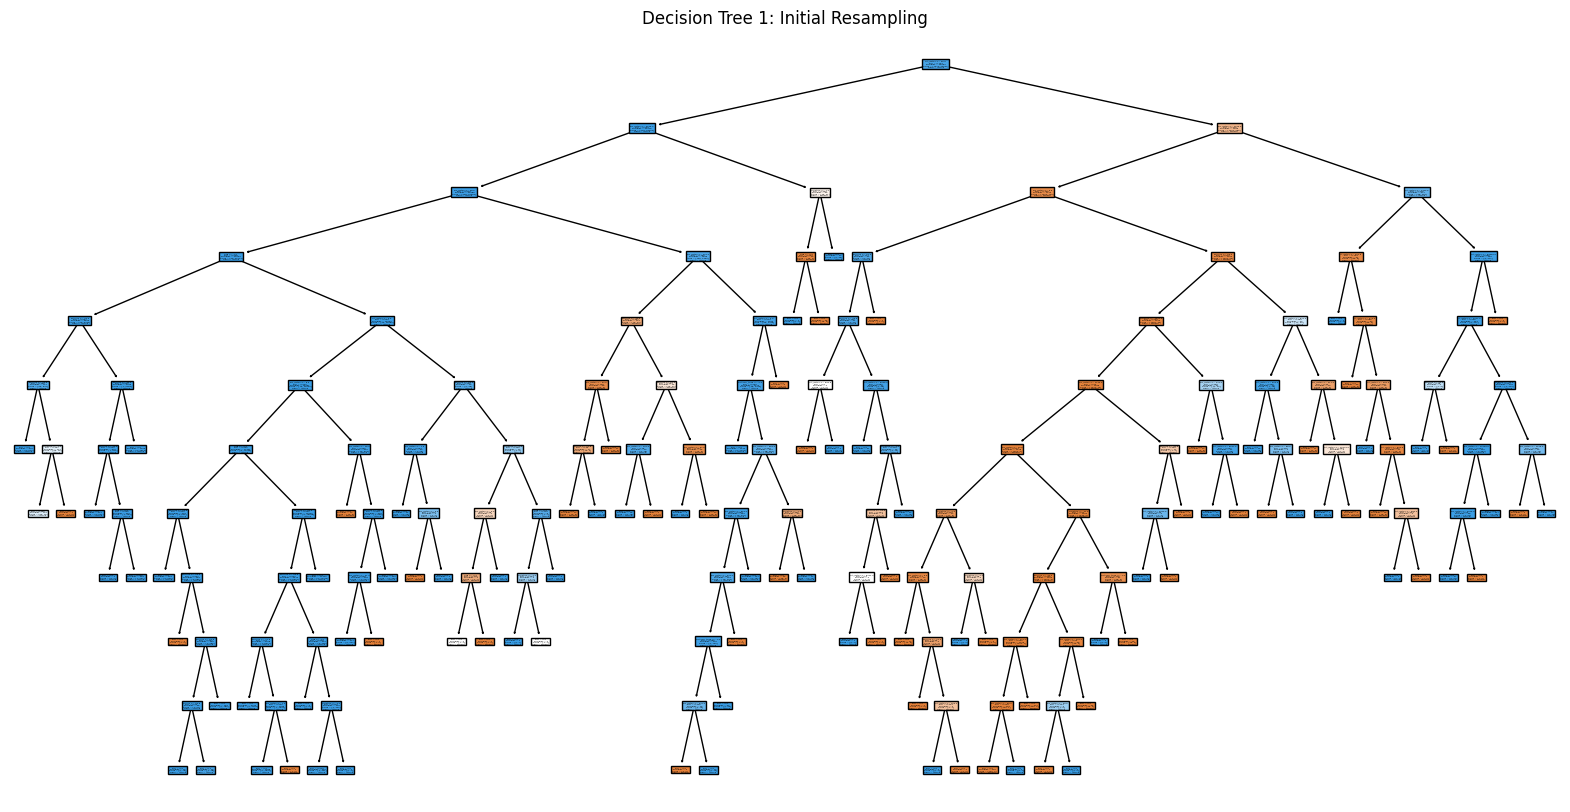

In [ ]:
# Plot the first decision tree
plt.figure(figsize=(20, 10))
plot_tree(tree1, filled=True, feature_names=to_fit.columns, class_names=['Normal', 'Attack'])
plt.title("Decision Tree 1: Initial Resampling")
plt.show()

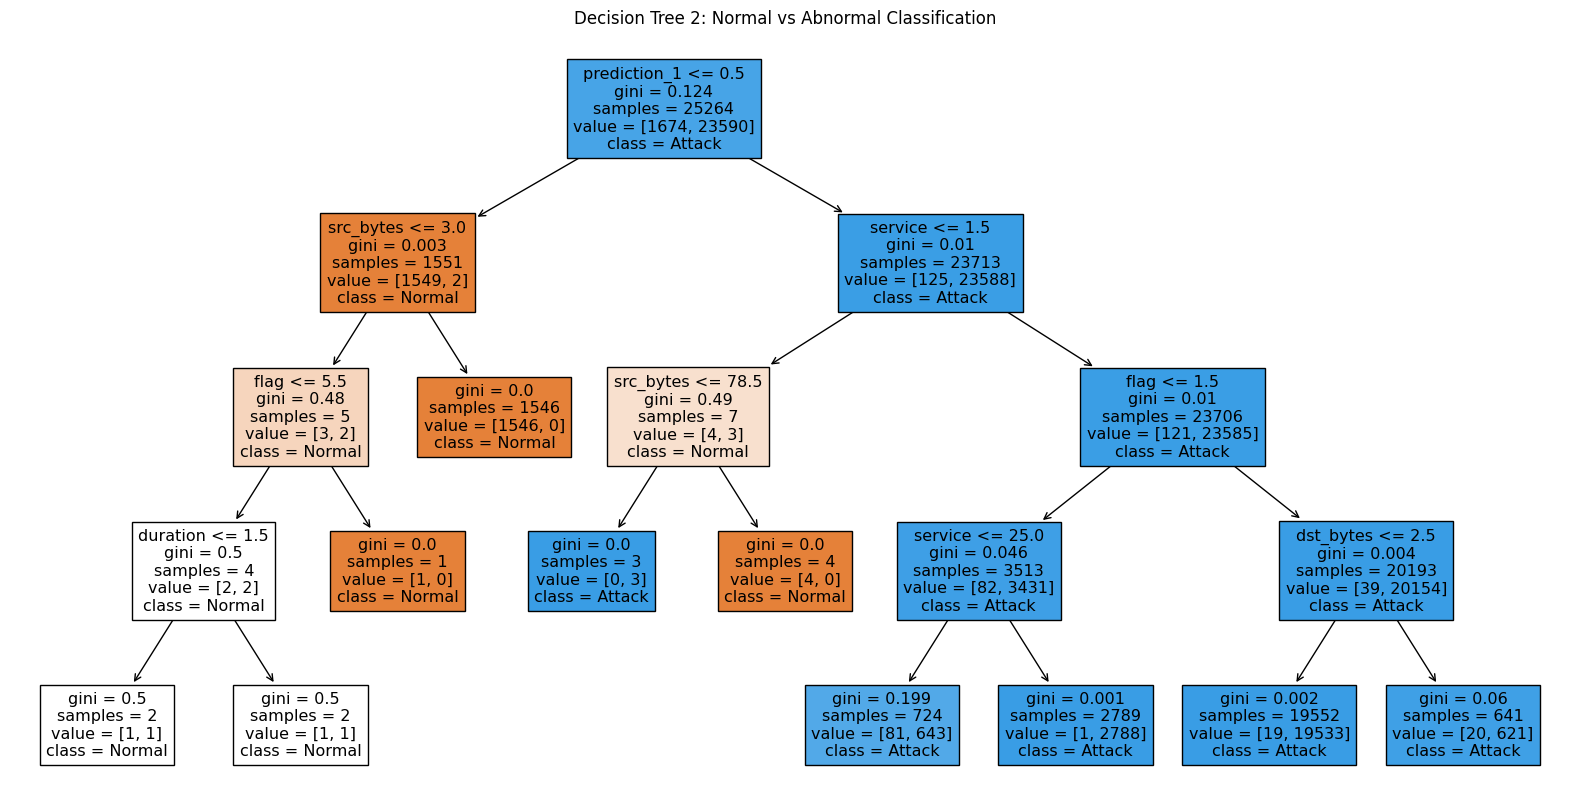

In [ ]:
# Plot the second decision tree
plt.figure(figsize=(20, 10))
plot_tree(tree2, filled=True, feature_names=binary_train_X.columns, class_names=['Normal', 'Attack'])
plt.title("Decision Tree 2: Normal vs Abnormal Classification")
plt.show()

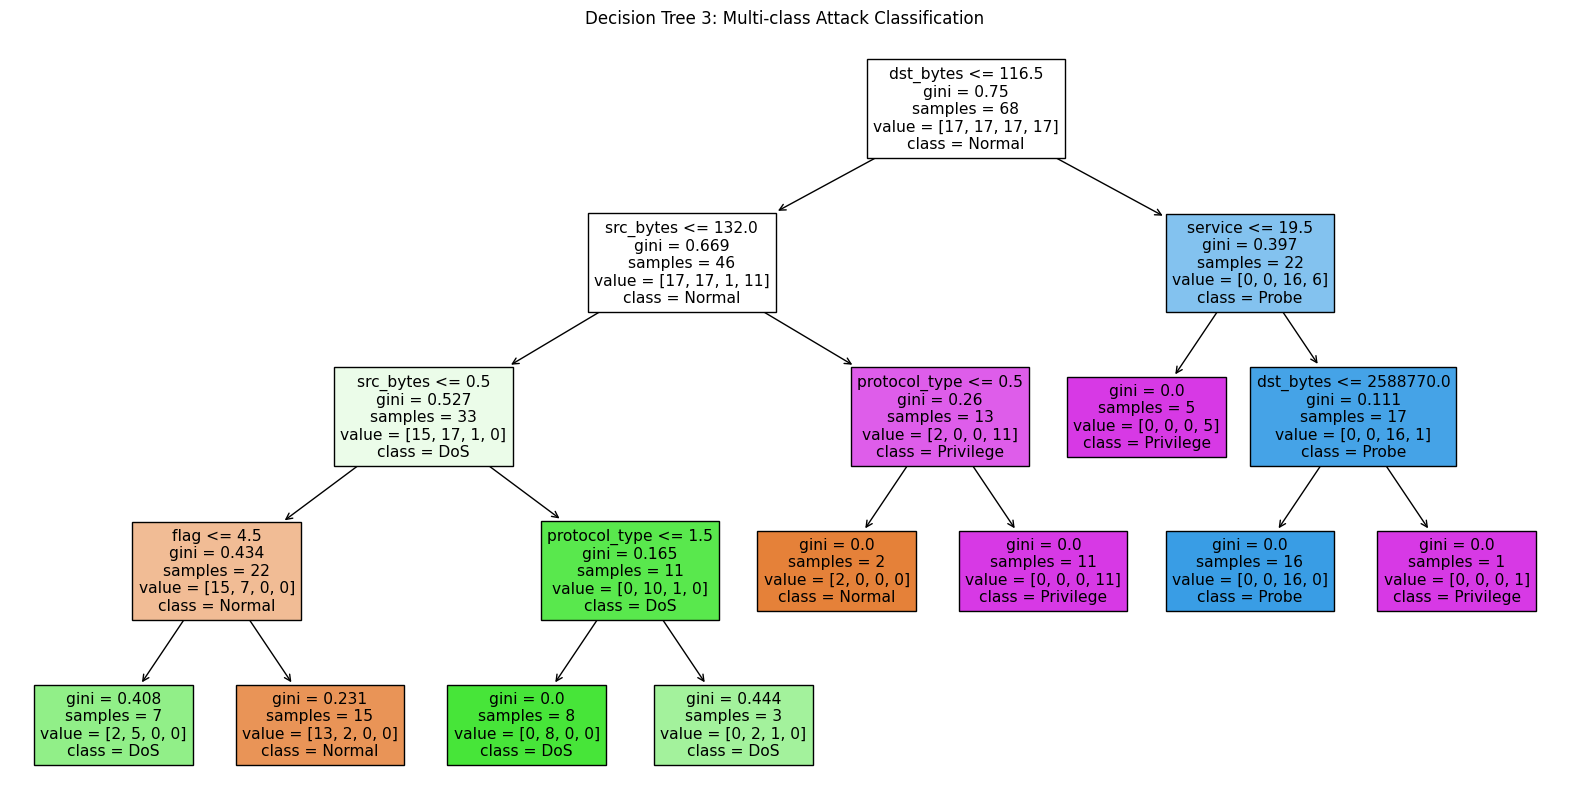

In [ ]:
# Plot the third decision tree
abnormal_features = abnormal_train_X.columns  # Use features from abnormal training data
plt.figure(figsize=(20, 10))
plot_tree(tree3, filled=True, feature_names=abnormal_features, class_names=attack_labels)
plt.title("Decision Tree 3: Multi-class Attack Classification")
plt.show()

In [ ]:
rf.fit(binary_train_X, binary_train_y)
rf_train_predictions = rf.predict(binary_train_X)
rf_val_predictions = rf.predict(binary_val_X)
rf_test_predictions = rf.predict(test_set)

rf_train_accuracy = accuracy_score(binary_train_y, rf_train_predictions)
rf_train_precision = precision_score(binary_train_y, rf_train_predictions)
rf_train_recall = recall_score(binary_train_y, rf_train_predictions)
rf_train_f1 = f1_score(binary_train_y, rf_train_predictions)

rf_val_accuracy = accuracy_score(binary_val_y, rf_val_predictions)
rf_val_precision = precision_score(binary_val_y, rf_val_predictions)
rf_val_recall = recall_score(binary_val_y, rf_val_predictions)
rf_val_f1 = f1_score(binary_val_y, rf_val_predictions)

rf_test_accuracy = accuracy_score(test_binary_y, rf_test_predictions)
rf_test_precision = precision_score(test_binary_y, rf_test_predictions)
rf_test_recall = recall_score(test_binary_y, rf_test_predictions)
rf_test_f1 = f1_score(test_binary_y, rf_test_predictions)

print("Random Forest Training Accuracy:", rf_train_accuracy)
print("Random Forest Training Precision:", rf_train_precision)
print("Random Forest Training Recall:", rf_train_recall)
print("Random Forest Training F1-Score:", rf_train_f1)

print("Random Forest Validation Accuracy:", rf_val_accuracy)
print("Random Forest Validation Precision:", rf_val_precision)
print("Random Forest Validation Recall:", rf_val_recall)
print("Random Forest Validation F1-Score:", rf_val_f1)

print("Random Forest Test Accuracy:", rf_test_accuracy)
print("Random Forest Test Precision:", rf_test_precision)
print("Random Forest Test Recall:", rf_test_recall)
print("Random Forest Test F1-Score:", rf_test_f1)


Random Forest Training Accuracy: 0.9946018893387314
Random Forest Training Precision: 0.9921070403511734
Random Forest Training Recall: 0.9963967782958881
Random Forest Training F1-Score: 0.9942472822638637
Random Forest Validation Accuracy: 0.9929085520745131
Random Forest Validation Precision: 0.9908108108108108
Random Forest Validation Recall: 0.9939212328767123
Random Forest Validation F1-Score: 0.9923635845562045
Random Forest Test Accuracy: 0.8152419819899747
Random Forest Test Precision: 0.9201978085910986
Random Forest Test Recall: 0.7395573566084788
Random Forest Test F1-Score: 0.8200475264635991


In [ ]:
knn.fit(binary_train_X, binary_train_y)
knn_train_predictions = knn.predict(binary_train_X)
knn_val_predictions = knn.predict(binary_val_X)
knn_test_predictions = knn.predict(test_set)

knn_train_accuracy = accuracy_score(binary_train_y, knn_train_predictions)
knn_train_precision = precision_score(binary_train_y, knn_train_predictions)
knn_train_recall = recall_score(binary_train_y, knn_train_predictions)
knn_train_f1 = f1_score(binary_train_y, knn_train_predictions)

knn_val_accuracy = accuracy_score(binary_val_y, knn_val_predictions)
knn_val_precision = precision_score(binary_val_y, knn_val_predictions)
knn_val_recall = recall_score(binary_val_y, knn_val_predictions)
knn_val_f1 = f1_score(binary_val_y, knn_val_predictions)

knn_test_accuracy = accuracy_score(test_binary_y, knn_test_predictions)
knn_test_precision = precision_score(test_binary_y, knn_test_predictions)
knn_test_recall = recall_score(test_binary_y, knn_test_predictions)
knn_test_f1 = f1_score(test_binary_y, knn_test_predictions)

print("KNN Training Accuracy:", knn_train_accuracy)
print("KNN Training Precision:", knn_train_precision)
print("KNN Training Recall:", knn_train_recall)
print("KNN Training F1-Score:", knn_train_f1)

print("KNN Validation Accuracy:", knn_val_accuracy)
print("KNN Validation Precision:", knn_val_precision)
print("KNN Validation Recall:", knn_val_recall)
print("KNN Validation F1-Score:", knn_val_f1)

print("KNN Test Accuracy:", knn_test_accuracy)
print("KNN Test Precision:", knn_test_precision)
print("KNN Test Recall:", knn_test_recall)
print("KNN Test F1-Score:", knn_test_f1)


KNN Training Accuracy: 0.9925379058505993
KNN Training Precision: 0.9901190777805928
KNN Training Recall: 0.9939805002119542
KNN Training F1-Score: 0.9920460314774072
KNN Validation Accuracy: 0.9914929085520745
KNN Validation Precision: 0.9888576220118814
KNN Validation Recall: 0.9928367579908676
KNN Validation F1-Score: 0.9908431950556101
KNN Test Accuracy: 0.8428780552721465
KNN Test Precision: 0.9668341708542714
KNN Test Recall: 0.7496882793017456
KNN Test F1-Score: 0.8445263804758142
